In [1]:
%pylab --no-import-all
%matplotlib inline
from sacla import *

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import idi.reconstruction as recon

In [3]:
l=log('2019 SACLA - Shotlog.csv')

In [4]:
import pandas as pd
pd.set_option('display.max_rows', 1000)

In [5]:
l

,Run start,last run,Starttime,Endtime,Sample,E_ph,Pre Comment,Pulse Energy,Detector Filter,Beamline filter,...,Sx speed,Sz min,Sz max,Sz spacing,Single_x,Single_y,Single_z,Prof_Y,Prof_X2,Prof_Z1
,#,#,Time,Time,#/desc,keV,desc,uJ,desc,mm Silicon,...,pulse/sec,pulses,pulses,pulses,microns,microns,microns,microns,microns,microns
0,781931,NaN,05:47:29,NaN,1,10.4,NaN,562.0,50um Zink,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,781932,781952.0,09:20:14,09:29:08,15,10.4,background,570.0,50um Zink,0.4,...,1200.0,-10000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
2,781953,781959.0,09:30:16,09:31:57,15,10.4,NaN,570.0,50um Zink,0.3,...,1200.0,-10000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
3,781960,781965.0,09:35:57,09:31:57,15,10.4,NaN,570.0,50um Zink,0.4,...,3600.0,-3000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
4,781966,781975.0,09:39:18,09:42:37,15,10.4,NaN,570.0,50um Zink,0.5,...,1200.0,-3000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
5,781976,781985.0,09:50:41,09:42:37,22x17 empty,10.4,empty 22x17 window,570.0,50um Zink,0.3,...,1200.0,-3000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
6,781976,781985.0,09:50:41,09:42:37,none,10.4,NaN,570.0,50um Zink,0.3,...,1200.0,-3000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
7,781976,781985.0,09:50:41,09:42:37,none,10.4,Stephan shielded from air scattering after tar...,570.0,50um Zink,0.3,...,1200.0,-3000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN
8,781976,781985.0,09:50:41,09:42:37,none,10.4,Tais shieded detector from upstream,570.0,50um Zink,0.3,...,1200.0,-3000.0,10000.0,80.0,6182.0,-5897.0,1500.0,3715.0,-1100.0,NaN


In [7]:
#to run: 97, 82, 83, 84, 87, 88, 93, 94
samples=[
     '23, Ben',
     '16, Ben',
     '#6',
    '22 GaN',
]

In [8]:
import glob
import os
def getlatest(search_dir=".",pattern='*',n=1):
    files = list(filter(os.path.isfile, glob.glob(search_dir +'/'+ pattern)))
    files = sorted(files,key=os.path.getmtime,reverse=True)[:n]
    if len(files)==1: return files[0]
    if len(files)==0: return None
    else: return tuple(files)

In [9]:
def append(dictionary,key,value):
    if not key in dictionary:
        dictionary[key]=[]
    dictionary[key].append(value)

In [10]:
for sample in samples:
    runs=l.search('Sample',sample)
    isatt=np.array(runs['Beamline filter']!='0')
    runs=runs[isatt]
    print(sample, end=': ')
    runs.apply(lambda r: print(r.name),axis=1)

23, Ben: 35
36
16, Ben: 31
32
#6: 29
30
22 GaN: 33


In [10]:
import datetime
def timestamp():
        return datetime.datetime.now().strftime('%y%m%d-%H%M%S')
print(timestamp())

190710-230200


In [6]:
import gc
import os
results={}
path='/work/gorkhover/zimmf/crystal/'
def append(dictionary,key,value):
    if not key in dictionary:
        dictionary[key]=[]
    dictionary[key].append(value)
def submit(r):
    runstart=int((r['Run start'][0]))
    runend=int(r['last run'][0])
    run=str(r.name)
    allres=dict()
    for cr in range(runstart,runend+1):
        filename=getlatest(path,f'{run}-{cr}-*',n=1)

        if filename is None: 
            print(r.name,cr,filename,'not found')
            continue
        print(r.name,cr,filename)
        try:
            file=np.load(filename)
            for k,v in file.items():
                if '3d' in k: continue
                print(k,end=' ')
                append(allres,k,v)
        except:
            print(f'error in {filename}')
        gc.collect()
    allres={k:np.array(v) for k,v in allres.items()}
    if not os.path.exists(f'{path}/output/'):
        os.makedirs(f'{path}/output/')
    np.savez_compressed(f'{path}/output/{run}_merged-{timestamp()}.npz',**allres)
    print(run,'saved')


In [11]:
sample=samples[1]
runs=l.search('Sample',sample)
r=runs.iloc[0]
r

Run start        #                                                        782181
last run         #                                                        782206
Starttime        Time                                                   06:09:23
Endtime          Time                                                   07:23:16
Sample           #/desc                                                 16, Bens
E_ph             keV                                                        10.4
Pre Comment      desc                                                        NaN
Pulse Energy     uJ                                                          535
Detector Filter  desc                                                  50um Zink
Beamline filter  mm Silicon                                                  0.5
Post Comment     desc          Noticed in the middle of the scan that we are ...
Single           Photons                                                     NaN
Dual             Photons    

In [12]:

runstart=int((r['Run start'][0]))
runend=int(r['last run'][0])
run=str(r.name)
for cr in range(runstart+1,runend+1):
    filename=getlatest(path,f'{run}-{cr}-*',n=1)
    if filename is None: 
        print(r.name,cr,filename,'not found')
        continue
    print(r.name,cr,filename)
    file=np.load(filename)
    for k,v in file.items():
        #if '3d' in k: continue
        print(k,end=' ')
        print(type(v), end=' ')
        try:
            print(v.size, end=' ')       
            if v.size==1:
                print(v)
            else:
                print(v.shape)
        except:
            continue
    break
#        try:
#             file=np.load(filename)
#             for k,v in file.items():
#                 if '3d' in k: continue
#                 print(k,end=' ')
#                 append(allres,k,v)
#         except:
#             print(f'error in {filename}')
#         gc.collect()
#     allres={k:np.array(v) for k,v in allres.items()}
    
#     np.savez_compressed(f'{path}/{run}_merged-{timestamp}.npz',**allres)
#     print(run,'saved')

31 782182 /work/gorkhover/zimmf/crystal/31-782182-190626-144011.npz
inputfile <class 'numpy.ndarray'> 1 /UserData/gorkhover/TAIS2019/782182.h5
outpath <class 'numpy.ndarray'> 1 /work/gorkhover/zimmf/crystal
workpath <class 'numpy.ndarray'> 1 /work/gorkhover/zimmf
run <class 'numpy.ndarray'> 1 31
simple <class 'numpy.ndarray'> 1 True
ft3d <class 'numpy.ndarray'> 1 True
direct <class 'numpy.ndarray'> 1 False
directrad <class 'numpy.ndarray'> 1 False
detector <class 'numpy.ndarray'> 1 detector_2d_1
energy <class 'numpy.ndarray'> 1 6450
z <class 'numpy.ndarray'> 1 4.0
photonsthreshold <class 'numpy.ndarray'> 1 500
pixelsize <class 'numpy.ndarray'> 1 50
maximg <class 'numpy.ndarray'> 1 -1
normalize <class 'numpy.ndarray'> 1 True
allimg <class 'numpy.ndarray'> 0 (0,)
allrad <class 'numpy.ndarray'> 1 False
delete <class 'numpy.ndarray'> 1 True
workfile <class 'numpy.ndarray'> 1 /work/gorkhover/zimmf/782182.h5
outfile <class 'numpy.ndarray'> 1 /work/gorkhover/zimmf/crystal/31-782182-190626-144

In [13]:
data=file['ft3d_mean']
mask=file['mask']
z=(file['z']*0.01)/(file['pixelsize']*1e-6)
norm=recon.ft.corr(mask,z)
res=data/norm
res[norm<1e3]=0
res=recon.ft.unwrap(res)
std=file['ft3d_std']/norm
std[norm<1e3]=0
std=recon.ft.unwrap(std)


/home/gorkhover/anaconda3/envs/zimmf/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/gorkhover/anaconda3/envs/zimmf/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/gorkhover/anaconda3/envs/zimmf/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/home/gorkhover/anaconda3/envs/zimmf/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [14]:
res[0,200:210,200:210]

array([[ 4.67331025e-04, -3.85920589e-04, -3.49971460e-05,
        -7.10067380e-05, -2.27102233e-04, -3.03054162e-05,
         3.34026256e-04, -7.52457687e-04, -6.82310743e-04,
        -1.14786316e-03],
       [-7.13453276e-04,  4.14546117e-04,  8.87558883e-04,
        -7.56644695e-05, -1.79803638e-04,  1.09257925e-04,
         2.99788133e-04, -1.88713906e-04, -1.66230335e-03,
         2.32788122e-04],
       [-7.57999127e-04, -9.58966919e-04,  7.38589917e-04,
         2.15046892e-04,  8.81847417e-04,  1.99567168e-04,
        -8.61562390e-05, -5.65579388e-05,  6.03880627e-04,
        -4.84665776e-04],
       [ 4.01254559e-04,  8.95806171e-04, -8.03145993e-04,
        -3.42473478e-04, -7.11364792e-04,  4.17690309e-04,
        -4.05488422e-04,  3.11937960e-04,  8.97147663e-04,
         5.62947231e-05],
       [ 4.93689461e-04, -9.15660330e-04, -4.75163658e-04,
        -3.12896530e-04, -2.18320939e-04,  6.66014495e-04,
        -1.22426114e-03, -7.39902684e-04,  4.44695786e-04,
        -2.

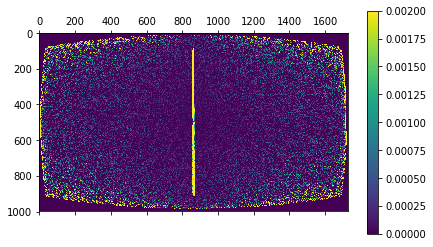

In [15]:
plt.matshow(res[2,...],vmin=0,vmax=0.002)
plt.colorbar()

In [16]:
import importlib
import idi.util as util
importlib.reload(util)

<module 'idi.util' from '/home/gorkhover/zimmf/idi/idi/util.py'>

In [34]:
cand=util.fftfilter_std(res,size=9,sigma=5)

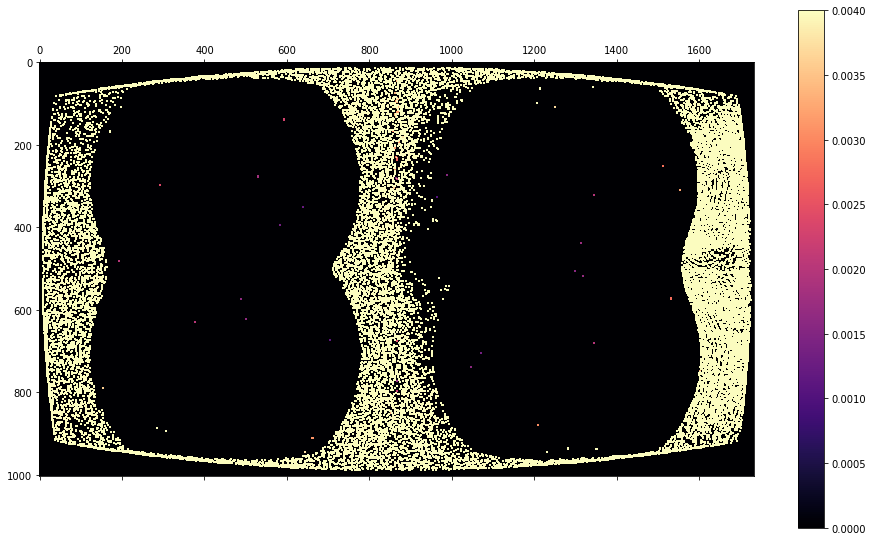

In [39]:

import scipy.signal as ss
plt.rcParams['figure.figsize']=(40,40)
t=np.nanmax((cand*res)[0:80,...],axis=0)
t=ss.convolve(t,np.ones((5,5)))
plt.matshow(t,vmin=0,vmax=0.004,cmap=plt.cm.magma)
plt.colorbar()
plt.savefig('ben1.png',dpi=300)

In [23]:
cand=util.fftfilter_std(res,size=10,sigma=5)

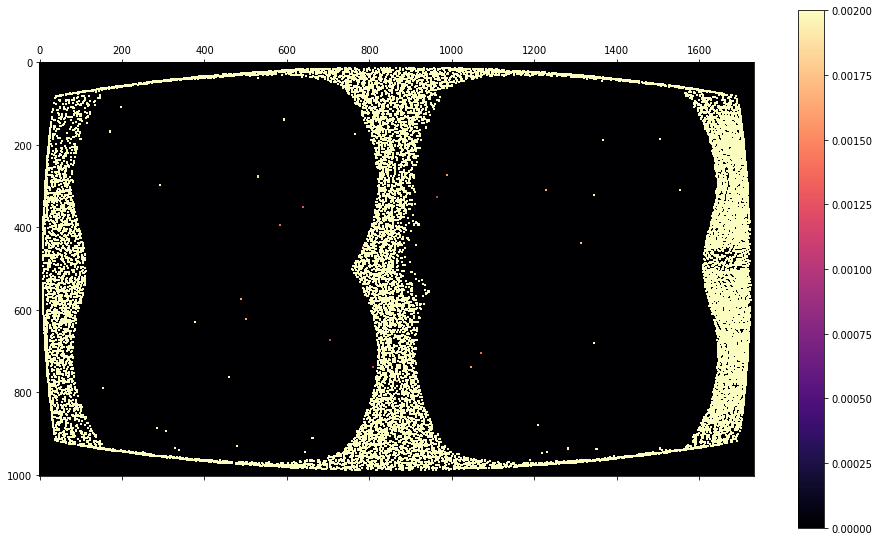

In [24]:

import scipy.signal as ss
plt.rcParams['figure.figsize']=(40,40)
t=np.nanmax((cand*res)[0:60,...],axis=0)
t=ss.convolve(t,np.ones((5,5)))
plt.matshow(t,vmin=0,vmax=0.002,cmap=plt.cm.magma)
plt.colorbar()
plt.savefig('ben1.png',dpi=300)

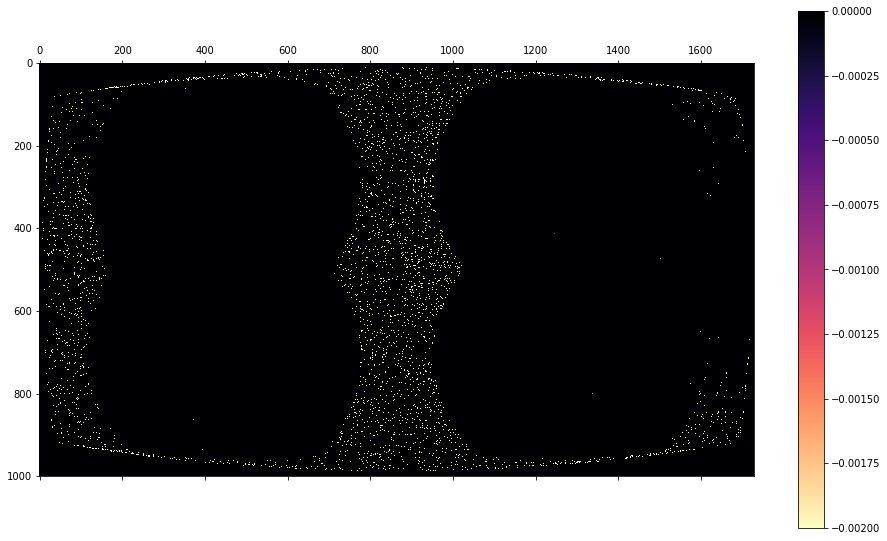

In [152]:
plt.rcParams['figure.figsize']=(40,40)
plt.matshow(np.nanmin((t*res)[0:80,...],axis=0),vmin=-0.002,vmax=0,cmap=plt.cm.magma_r)
plt.colorbar()

In [30]:
import scipy.ndimage as ndi
cand=abs(res)>abs(std)*.5
cand=ndi.morphology.binary_dilation(cand,np.ones((5,5,5)))


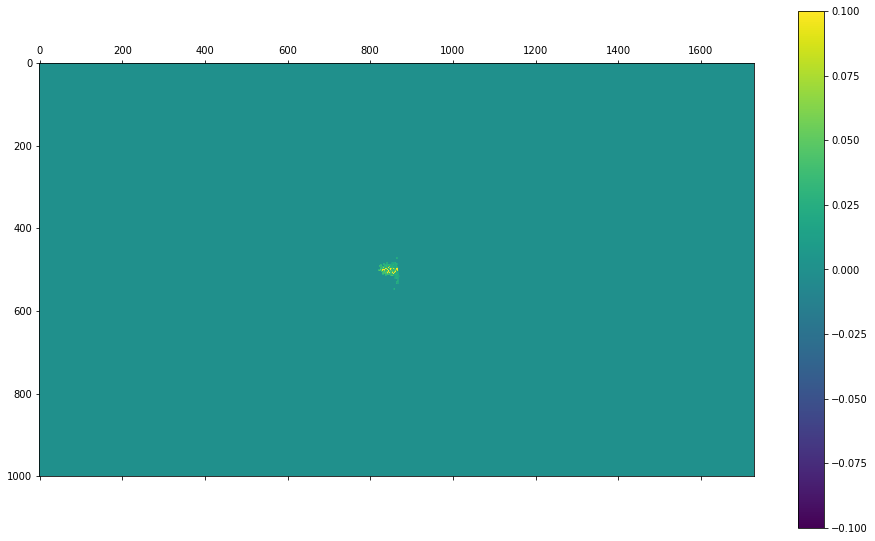

In [29]:


plt.rcParams['figure.figsize']=(20,20)


plt.matshow(np.nanmax((res*cand)[:100,...],axis=0),vmin=-0.1,vmax=0.1)
plt.colorbar()

In [31]:
local_std=ndi.generic_filter(res,np.std,size=5)

In [39]:
cand=abs(res)>abs(local_std)*3
#cand=ndi.morphology.binary_dilation(cand,np.ones((5,5,5)))

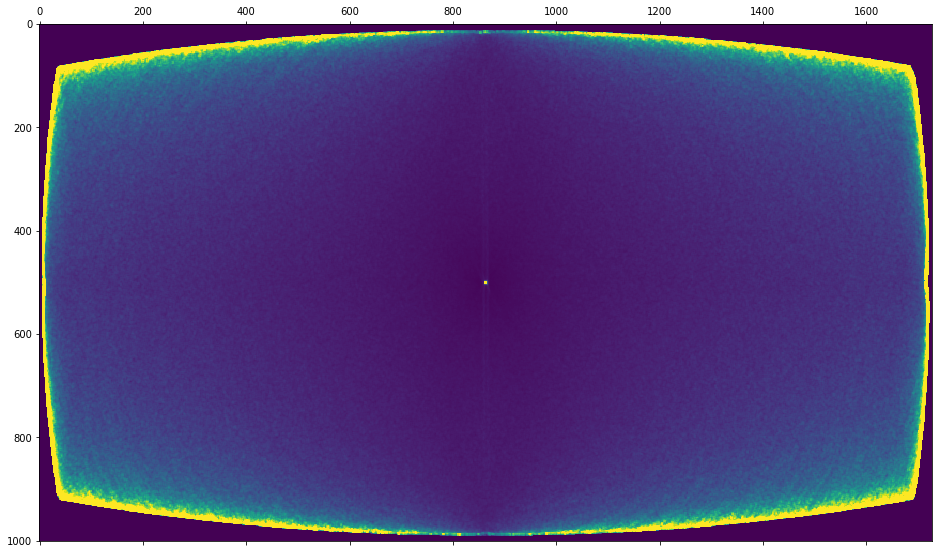

In [34]:
plt.matshow(local_std[0,...],vmin=0,vmax=0.1)

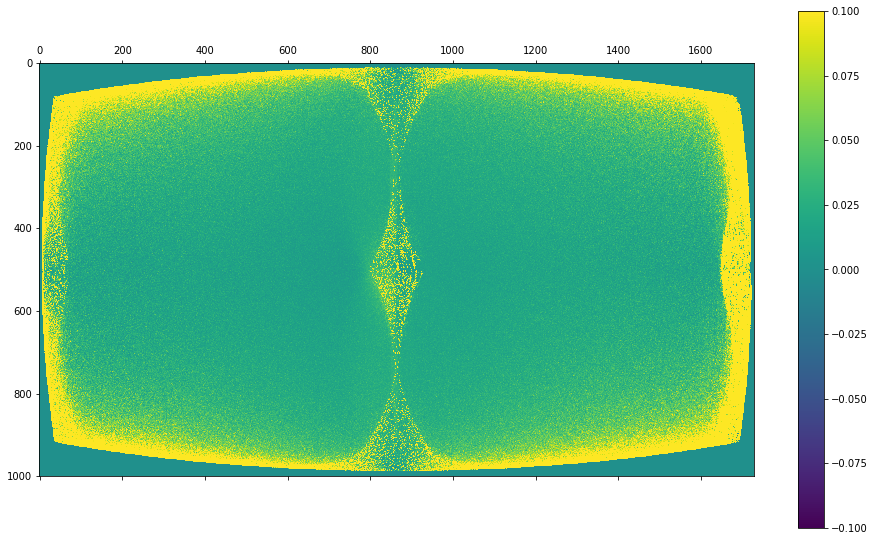

In [37]:


plt.rcParams['figure.figsize']=(20,20)


plt.matshow(np.nanmax((res*cand)[:40,...],axis=0),vmin=-0.1,vmax=0.1)
plt.colorbar()

In [14]:
# for sample in samples:
#     runs=l.search('Sample',sample)
#     isatt=np.array(runs['Beamline filter']!='0')
#     runs=runs[isatt]
#     runs.apply(submit,axis=1)


35 782273 /work/gorkhover/zimmf/crystal/35-782273-190625-224937.npz
inputfile outpath workpath run simple direct directrad detector energy z photonsthreshold pixelsize maximg normalize allimg allrad delete workfile outfile mask meanphotons stdphotons maxphotons nphotonsmax nphotonsmin photonsum bg mindist shotmean shotstd Nimg simplerad_all directrad_all simple_mean direct_mean directrad_mean simple_std direct_std directrad_std 35 782274 /work/gorkhover/zimmf/crystal/35-782274-190625-224936.npz
inputfile outpath workpath run simple direct directrad detector energy z photonsthreshold pixelsize maximg normalize allimg allrad delete workfile outfile mask meanphotons stdphotons maxphotons nphotonsmax nphotonsmin photonsum bg mindist shotmean shotstd Nimg simplerad_all directrad_all simple_mean direct_mean directrad_mean simple_std direct_std directrad_std 35 782275 /work/gorkhover/zimmf/crystal/35-782275-190625-224936.npz
inputfile outpath workpath run simple direct directrad detector ener

/home/gorkhover/anaconda3/envs/zimmf/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/gorkhover/anaconda3/envs/zimmf/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [40]:
a=3*[3]
np.ones(a)
res.ndim

3

In [47]:
import scipy.ndimage as ndi
def ismaximum(data, range=3):
    footprint = np.ones(data.ndim*[range])
    filtered = ndi.maximum_filter(data, footprint=footprint)
    ismaximum = data == filtered
    return ismaximum
def coords(mask):
    return np.asarray(np.where(mask)).T

In [ ]:
plt.matshow(res[0,...])
plt.colorbar()

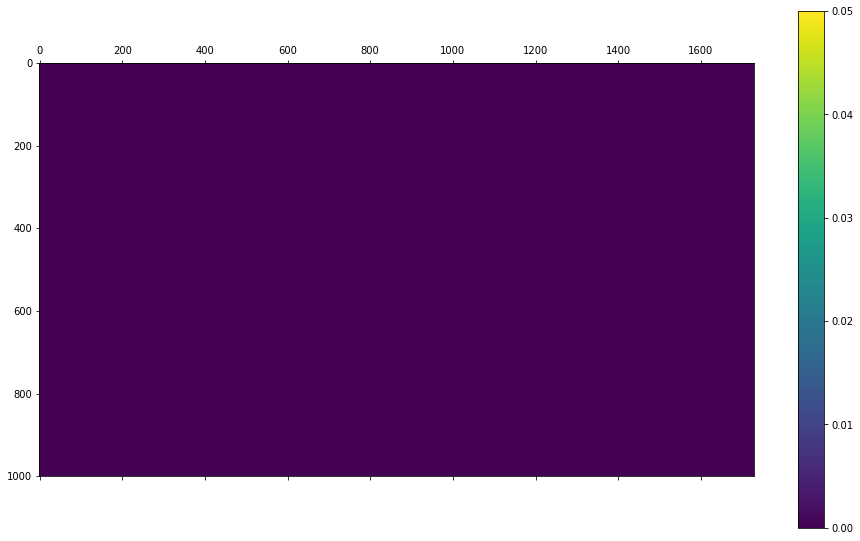

In [20]:
plt.rcParams['figure.figsize']=(20,20)
plt.matshow(np.nanmax(res[0:40,...],axis=0),vmax=0.05,vmin=0)
plt.colorbar()

In [62]:
maxima=ismaximum(res,2)

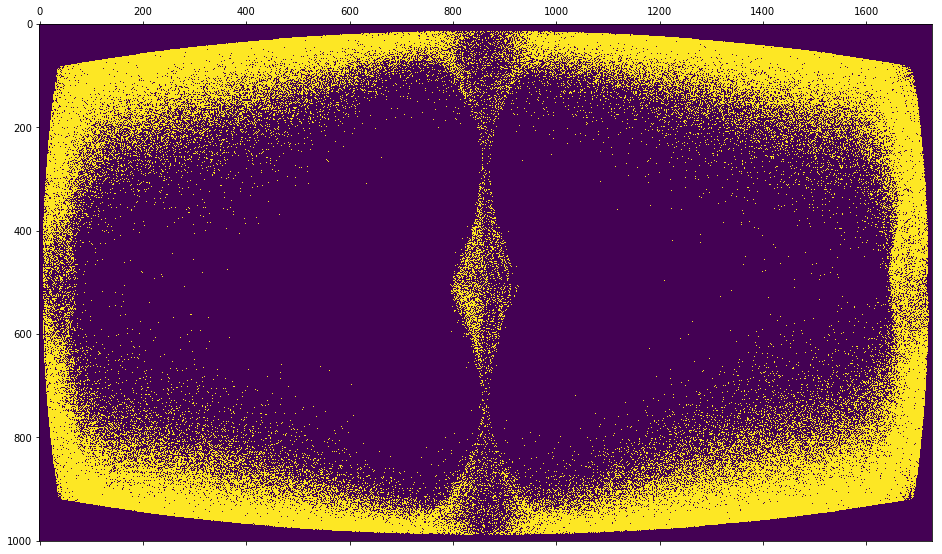

In [74]:
plt.rcParams['figure.figsize']=(50,50)
plt.matshow(np.nanmax((res*maxima)[:40,...],axis=0)>0.04,vmin=0,vmax=0.1)

In [121]:
merged=np.load('/work/gorkhover/zimmf/norm/82_merged.npz',allow_pickle=True)

In [9]:
list(merged.keys())

['inputfile',
 'outpath',
 'workpath',
 'run',
 'simple',
 'direct',
 'directrad',
 'detector',
 'energy',
 'z',
 'photonsthreshold',
 'pixelsize',
 'maximg',
 'allimg',
 'normalize',
 'allrad',
 'workfile',
 'outfile',
 'mask',
 'meanphotons',
 'stdphotons',
 'maxphotons',
 'nphotonsmax',
 'nphotonsmin',
 'photonsum',
 'bg',
 'mindist',
 'shotmean',
 'shotstd',
 'Nimg',
 'simplerad_all',
 'directrad_all',
 'simple_mean',
 'direct_mean',
 'directrad_mean',
 'simple_std',
 'direct_std',
 'directrad_std']

In [86]:
#nphotonsmax,nphotonsmin,photonsum=merged['nphotonsmax'],merged['nphotonsmin'],merged['photonsum']

In [14]:
!ls /work/gorkhover/zimmf/norm/*_merged2.npz

/work/gorkhover/zimmf/norm/72_merged2.npz
/work/gorkhover/zimmf/norm/73_merged2.npz
/work/gorkhover/zimmf/norm/82_merged2.npz
/work/gorkhover/zimmf/norm/87_merged2.npz
/work/gorkhover/zimmf/norm/89_merged2.npz
/work/gorkhover/zimmf/norm/91_merged2.npz
/work/gorkhover/zimmf/norm/93_merged2.npz
/work/gorkhover/zimmf/norm/97_merged2.npz


In [29]:
merged0=np.load('/work/gorkhover/zimmf/norm/80_merged2.npz',allow_pickle=True)
mask0=merged0['mask'][0,...]
import idi.reconstruction as recon
import idi.util as util
f=recon.newrad.corrfunction(mask0.shape,0.1/50e-6,100)
norm0=f(mask0)

simplenorm0=recon.simple.corr(mask0)
simplenorm0=util.radial_profile(simplenorm0,np.array(simplenorm0.shape)//2)

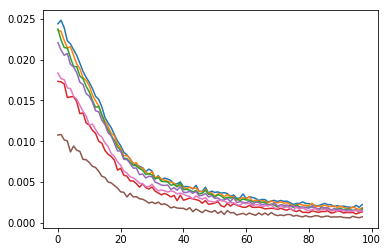

In [28]:
for n,r in enumerate(merged0['simplerad_all'][0]):
    plt.plot((r/simplenorm0)[2:100])
    if n>5: break

In [30]:
merged10=np.load('/work/gorkhover/zimmf/norm/82_merged2.npz',allow_pickle=True)
mask10=merged10['mask'][0,...]

simplenorm10=recon.simple.corr(mask10)
simplenorm10=util.radial_profile(simplenorm10,np.array(simplenorm10.shape)//2)

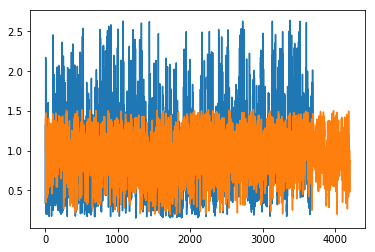

In [48]:
plt.plot(merged10['shotmean'][0])
plt.plot(merged0['shotmean'][0])

(1146,)
(1146,)
(1146,)
(1146,)
(1146,)
(1146,)
(1146,)
(1146,)
(1146,)
(1146,)
(1146,)
(1146,)
(1146,)
(1146,)
(1146,)
(1146,)
(1146,)
(1146,)
(1146,)
(1146,)
(1146,)
(1146,)


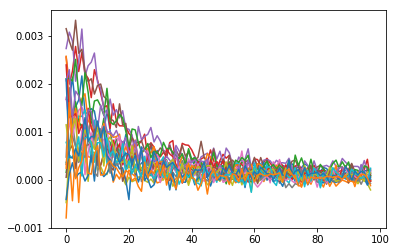

In [49]:
for n,r in enumerate(merged10['simplerad_all'][0]):
    print(r.shape)
    plt.plot((r/simplenorm10)[2:100])
    if n>20: break

In [50]:
new=np.load('/work/gorkhover/zimmf/new/82-782398-190530-025840.npz')

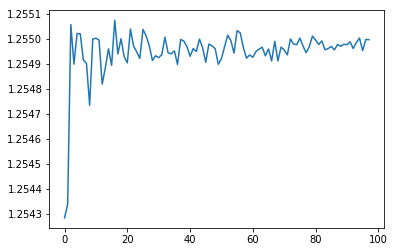

In [66]:
newmask=new['mask']
f=recon.newrad.corrfunction(newmask.shape,0.1/50e-6,100)
newnorm=f(newmask.astype(float))
r=(new['directrad_mean'])
plt.plot((r/newnorm)[2:100])

In [62]:
newmask.shape

(512,)

In [26]:
merged0=np.load('/work/gorkhover/zimmf/norm/80_merged2.npz',allow_pickle=True)
mask0=merged0['mask'][0,...]
import idi.reconstruction as recon
import idi.util as util
f=recon.newrad.corrfunction(mask0.shape,0.1/50e-6,100)
norm0=f(mask0)



(1146,)

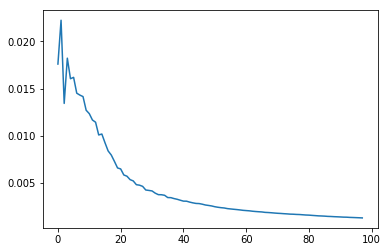

In [185]:

merged0=np.load('/work/gorkhover/zimmf/norm/80_merged2.npz',allow_pickle=True)
dm0=merged0['directrad_mean']
mask0=merged0['mask'][0,...]
import idi.reconstruction as recon
f=recon.newrad.corrfunction(mask0.shape,0.1/50e-6,100)
norm0=f(mask0)
r0=dm0[0,:]/norm0
#r0=r0/(r0[2]) #normalisation
plt.plot(r0[2:])

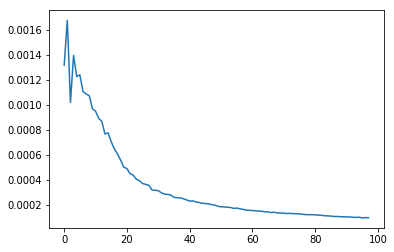

In [184]:
import idi.reconstruction as recon


merged10=np.load('/work/gorkhover/zimmf/norm/82_merged2.npz',allow_pickle=True)
dm10=merged10['directrad_mean']
mask10=merged10['mask'][0,...]
f=recon.newrad.corrfunction(mask.shape,0.1/50e-6,100)
norm10=f(mask10)
r10=dm10[0,:]/norm10
#r10=r10/(r10[2]) #normalisation
plt.plot(r10[2:])

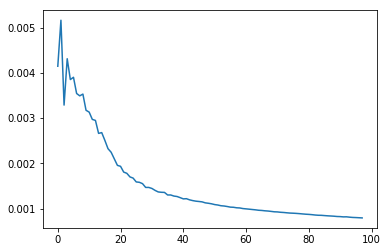

In [192]:
import idi.reconstruction as recon


merged20=np.load('/work/gorkhover/zimmf/norm/72_merged2.npz',allow_pickle=True)
dm20=merged20['directrad_mean']
mask20=merged20['mask'][0,...]
f=recon.newrad.corrfunction(mask20.shape,0.1/50e-6,100)
norm20=f(mask20)
r20=dm20[0,:]/norm20
#r20=r20/(r20[2]) #normalisation
plt.plot(r20[2:])

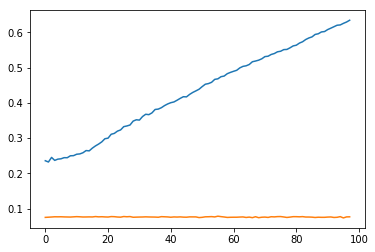

In [196]:
plt.plot((r20/r0)[2:])
plt.plot((r10/r0)[2:])
#plt.plot((r10-r0)[2:])

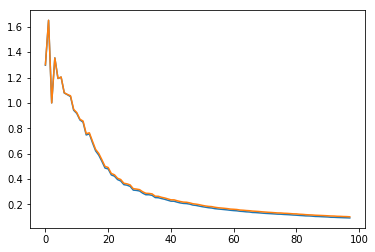

In [172]:
r1=dm1/norm1
r0=dm/norm
r1=(np.mean(r1[:,2:],axis=0))
r0=(np.mean(r0[:,2:],axis=0))
r1=r1/(r1[2])
r0=r0/(r0[2])

plt.plot(r0)
plt.plot(r1)



In [20]:
dm

array([[514217.45911374,   6315.38281268,   4723.74266939, ...,
         12535.66097687,  12977.58972383,  12945.25203191],
       [514375.24480165,   7213.70370649,   5777.30044338, ...,
         15367.40654148,  15753.55038442,  15431.60974057],
       [514300.99938021,   6806.72624079,   5329.6128654 , ...,
         14473.36159192,  14437.45718636,  14393.62813134],
       ...,
       [514708.35555989,   8878.58202426,   7746.48378954, ...,
         21428.87676304,  21098.83921565,  21156.35684817],
       [514746.65732159,   9081.54170381,   7938.46961729, ...,
         22187.68999725,  21733.54623803,  21663.48782084],
       [514465.46668786,   7529.36570635,   6083.49608517, ...,
         16635.16477989,  16831.72353408,  16890.38973608]])

In [9]:
!ls /work/gorkhover/zimmf/norm/*merged*.npz

/work/gorkhover/zimmf/norm/72_merged2.npz
/work/gorkhover/zimmf/norm/73_merged2.npz
/work/gorkhover/zimmf/norm/74_merged2.npz
/work/gorkhover/zimmf/norm/79_merged2.npz
/work/gorkhover/zimmf/norm/80_merged2.npz
/work/gorkhover/zimmf/norm/82_merged2.npz
/work/gorkhover/zimmf/norm/82_merged.npz
/work/gorkhover/zimmf/norm/87_merged2.npz
/work/gorkhover/zimmf/norm/87_merged.npz
/work/gorkhover/zimmf/norm/89_merged2.npz
/work/gorkhover/zimmf/norm/89_merged.npz
/work/gorkhover/zimmf/norm/91_merged2.npz
/work/gorkhover/zimmf/norm/91_merged.npz
/work/gorkhover/zimmf/norm/93_merged2.npz
/work/gorkhover/zimmf/norm/93_merged.npz
/work/gorkhover/zimmf/norm/97_merged2.npz
/work/gorkhover/zimmf/norm/97_merged.npz


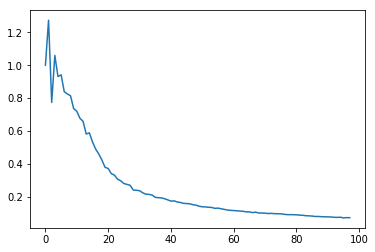

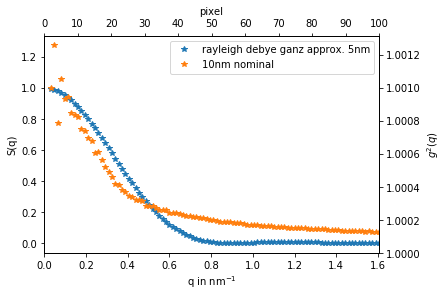

In [154]:

import scipy.special

def rdg(q,r,a=1,b=0):
    '''
    rayleigh debye ganz approximation for scattering of a sphere.
    returns a*P+b
    '''
    j1=lambda x: scipy.special.spherical_jn(1, x)
    q=np.clip(q, 1e-100, None) #avoid singularity at q==0 to allow fitting
    p=(3*j1(q*r)/(q*r))**2
    return a*p+b


e=6400
l=(1239.0/e)*1e-9
pixel=np.arange(0,100)
theta=0.5*np.arctan2(pixel*50e-6,0.1)
q=(2*np.pi/l)*2*np.sin(theta)
I=rdg(q,5e-9)


def profile_plot(I,l,q,f='plot'):
    if f not in ['loglog','semilogy','plot']: raise NotImplementedError(f'function {f} not implemented')
    pixel=list(range(len(q)+9))
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    pf=getattr(ax1,f)
   
    if not isinstance(I,list): I=[I]
    if not isinstance(l,list): l=[l]
    for i,l in zip(I,l):  
        pf(q/1e9,i,'*',label=l)
    ax1.set_xlabel(r"q in nm$^{-1}$")
   

    if not 'loglog' in f:

        ax1.set_xlim((0,np.max(q)/1e9))
        ax1.set_ylabel('S(q)')       
        ax2 = ax1.twiny()
        ax3 = ax1.twinx()
        ax3.set_ylim((1,1+1/760))
        ax3.set_ylabel(r'$g^2(q)$')
        ax2.set_xlabel(r"pixel")
        ax2.set_xlim(ax1.get_xlim())
        ax2.set_xticks((pixel[::10]/np.max(pixel)*np.max(q)))
        ax2.set_xticklabels(pixel[::10])
    ax1.legend()
    plt.savefig('run82-1.png')
    plt.show()
    
profile_plot([I[2:],r[2:]],['rayleigh debye ganz approx. 5nm',r'10nm nominal'],q[2:])

In [155]:
!pwd

/home/gorkhover/zimmf


In [140]:
r=dm[0,:]/norm

In [142]:
1/r[2]

758.1166567784941

In [94]:
for ps,nmax,nmin in zip(photonsum,nphotonsmax,nphotonsmin):
    ok=np.logical_and(ps>nmin,ps<nmax)
    print(np.sum(ok))

3734
3768
3790
3801
3797
3772
3772
3053
2764
3790
3819
3824
3826
3815
3811
2452


In [69]:
t=merged['directrad_mean'],mask=merged['mask']

In [70]:
std=merged['directrad_std'][1]

In [71]:
f=recon.newrad.corrfunction(mask.shape,0.1/50e-6,100)

In [72]:
norm=f(mask)

In [84]:
w=np.hanning(8)
w=w/np.sum(w)

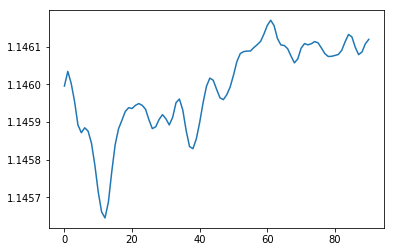

In [85]:
plt.plot(np.convolve((t/norm)[2:100],w,mode='valid'))

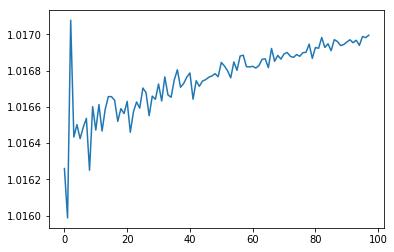

In [65]:
plt.plot((std/norm)[2:])

In [16]:
mean=np.nanmean(np.array(res),axis=0)

In [17]:
np.nanmin(mean[600:-600,300:-300])

1.1669560183208267

In [19]:
np.nanmedian(mean[600:-600,300:-300])

1.1692600428447295

In [42]:
plt.rcParams['figure.figsize']=(15,15)
def plot(img):
    cimg=img[900:-900,400:-400]
    vmin=np.percentile(img,20)
    vmax=np.percentile(img,90)
    plt.matshow(img,vmin=vmin,vmax=vmax)
    plt.show()

In [15]:
from idi.util import radial_profile

10 mid
0 1 2 3 

/home/gorkhover/anaconda3/envs/zimmf/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 plot:


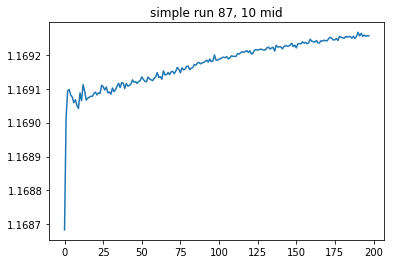

10 low
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 plot:


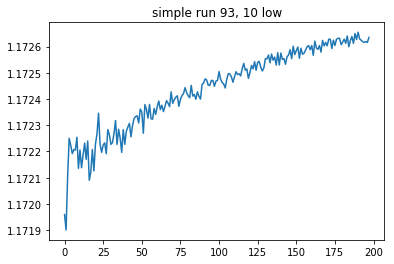

51, 10 high
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 0 1 2 3 4 5 6 7 8 9 10 11 12 

/home/gorkhover/anaconda3/envs/zimmf/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in add
  from ipykernel import kernelapp as app


13 14 15 16 17 18 19 20 plot:


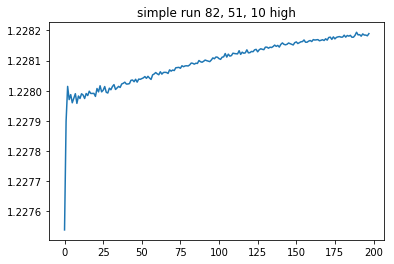

10 agar
0 1 2 3 4 5 6 7 8 9 10 11 12 13 0 1 2 3 4 5 6 7 8 9 10 11 12 13 plot:


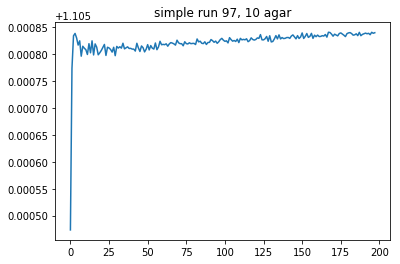

5 mid
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 

MemoryError: occurred at index 89

In [109]:
res={}
rad={}
def plot(run):
    nr=run.name
    sample=(run['Sample'].iloc[0])
    merged=np.load(f'/work/gorkhover/zimmf/more/{nr}_merged.npz',allow_pickle=True)
    res[nr]=[]
    
    for i,(m,s) in enumerate(zip(merged['mask'],merged['simple_mean'])):
        print(i, end=' ')
        
        norm=recon.simple.corr(m)
        res[nr].append(s/norm)
    rad[nr]=0
    for i,r in enumerate(res[nr]):
        rad[nr]+=radial_profile(r,np.array(r.shape)//2)
        print(i, end=' ')
    print('plot:')
    rad[nr]=rad[nr]/(i+1)
    plt.plot(rad[nr][2:200])
    plt.title(f'simple run {nr}, {sample}')
    plt.show()





for sample in samples:
    runs=l.search('Sample',sample)
    isatt=np.array(runs['Beamline filter']!='0')
    runs=runs[isatt]
    print(sample)
    runs.apply(plot,axis=1)


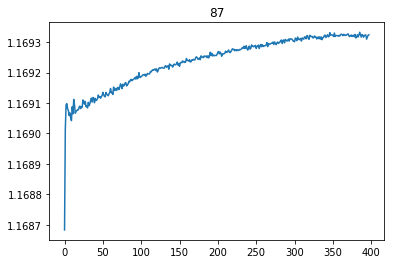

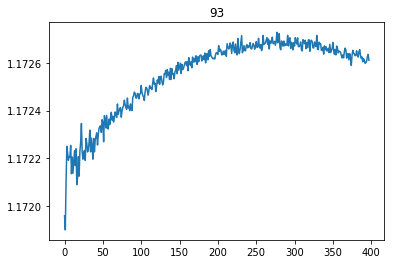

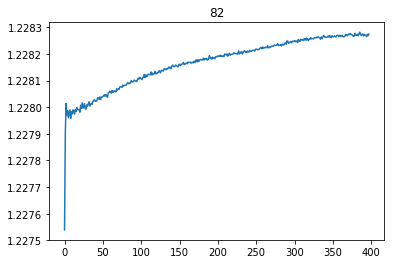

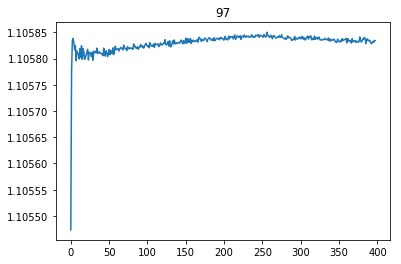

In [117]:
for n,r in rad.items():
    plt.plot(r[2:400],label=n)
    plt.title(n)
    ax = plt.gca()
    ax.ticklabel_format(useOffset=False)
    plt.show()

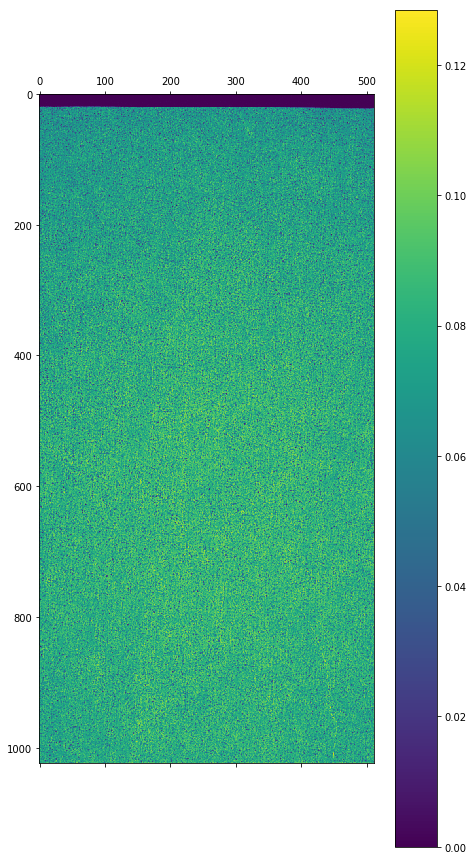

In [38]:
plt.matshow(p[0,...])
plt.colorbar()

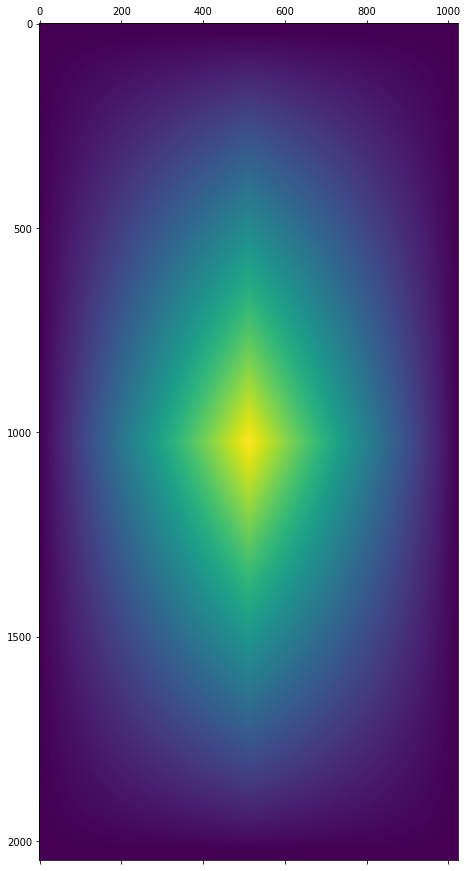

In [43]:
plt.matshow(norm)

In [75]:
t=np.array((1,2,3,4))

In [77]:
np.std(5*t)/5

1.118033988749895

In [79]:
res.nbytes/1024/1024

1977.5390625

In [82]:
!free -h

             total       used       free     shared    buffers     cached
Mem:           62G        50G        12G       2.4M       189M        31G
-/+ buffers/cache:        18G        44G 
Swap:          31G       138M        31G 


In [81]:
whos

Variable       Type                          Data/Info
------------------------------------------------------
Pool           type                          <class 'multiprocess.pool.Pool'>
Tais2019       dict                          n=3
a              list                          n=3
append         function                      <function append at 0x2ba05bac1ea0>
asgen          function                      <function asgen at 0x2ba0587a0400>
aslengen       function                      <function aslengen at 0x2ba0587a07b8>
aslist         function                      <function aslist at 0x2ba0587a0488>
chain          function                      <function chain at 0x2ba0587a0950>
coords         function                      <function coords at 0x2ba288be6b70>
cr             int                           782240
datetime       module                        <module 'datetime' from '<...>b/python3.7/datetime.py'>
deque          type                          <class 'collections.deque'>
fi

In [100]:
t=np.zeros(int(1024/8*1024*1024*40))

In [102]:
t[:]=100

In [104]:
del t

In [105]:
!free -h

             total       used       free     shared    buffers     cached
Mem:           62G        22G        40G       2.4M       100M       7.2G
-/+ buffers/cache:        14G        47G 
Swap:          31G       139M        31G 
